<a href="https://colab.research.google.com/github/Neel-K26/Image-segemention-using-PYTORCH/blob/main/IMAGE_SEGMENTATION_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [68]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ze2fufg7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ze2fufg7
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [69]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


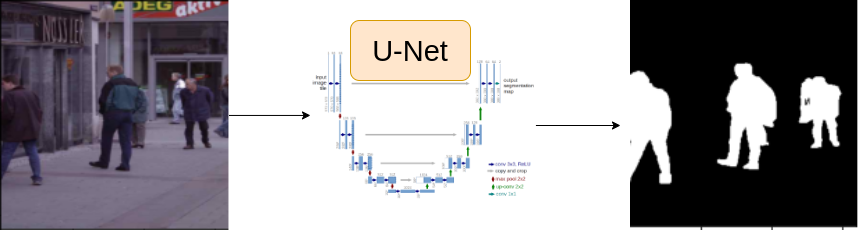

# Some Common Imports

In [70]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [71]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [72]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 25
BATCH_SIZE = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [73]:
df= pd.read_csv(f'{CSV_FILE}/train.csv')
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [74]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks
image= cv2.imread(image_path,1)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask= cv2.imread(mask_path,0)

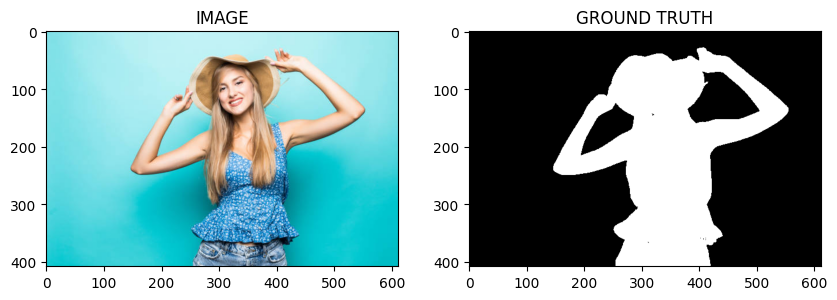

In [75]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [76]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [77]:
import albumentations as A

In [78]:
def get_train_augs():
  train_transform = A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
  return train_transform

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [79]:
from torch.utils.data import Dataset

In [99]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import albumentations as A

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize image and mask to IMAGE_SIZE x IMAGE_SIZE before augmentations
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))


    mask=np.expand_dims(mask, axis=-1)


    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c)-->(c,h,v)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.tensor(image) /255.0
    mask = torch.round(torch.tensor(mask) /255.0)
    return image, mask

In [100]:
trainset= SegmentationDataset(train_df, get_train_augs())
validset= SegmentationDataset(valid_df, get_valid_augs())

In [101]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


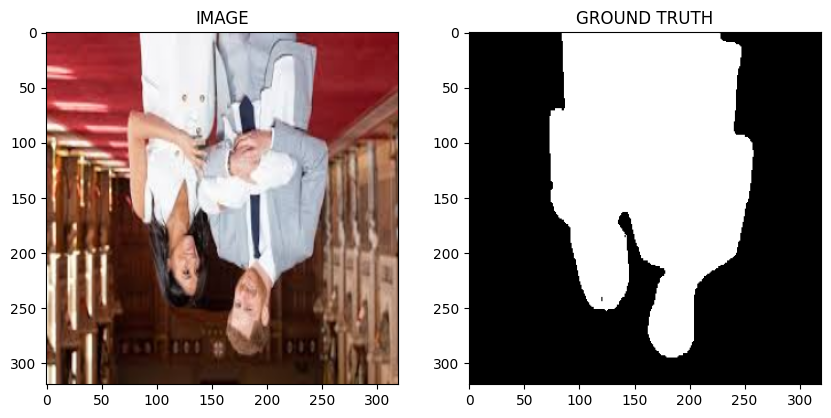

In [102]:
idx = 20
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [103]:
from torch.utils.data import DataLoader

In [104]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print(f"Number of batches in trainloader: {len(trainloader)}")
print(f"Number of batches in validloader: {len(validloader)}")

Number of batches in trainloader: 15
Number of batches in validloader: 4


In [105]:
# Hi




# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [106]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [118]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,      # RGB images
        classes=1,
        activation=None,
        # Binary segmentation (human vs background)
    )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    else:
      return logits

In [119]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [120]:
def train_fn(loader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images , masks in tqdm(loader) :
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(loader)

In [121]:
def eval_fn(loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
   for images , masks in tqdm(loader) :
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    logits, loss = model(images, masks)

    total_loss += loss.item()

  return total_loss / len(loader)

# Task 8 : Train Model

In [122]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [123]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved best model!")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Saved best model!
Epoch: 1 Train Loss: 1.3326 Valid Loss: 1.2664


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Saved best model!
Epoch: 2 Train Loss: 1.0880 Valid Loss: 0.8630


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Saved best model!
Epoch: 3 Train Loss: 0.8564 Valid Loss: 0.6885


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Saved best model!
Epoch: 4 Train Loss: 0.7177 Valid Loss: 0.6003


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Saved best model!
Epoch: 5 Train Loss: 0.6258 Valid Loss: 0.5546


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Saved best model!
Epoch: 6 Train Loss: 0.5607 Valid Loss: 0.5143


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Saved best model!
Epoch: 7 Train Loss: 0.5259 Valid Loss: 0.4832


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Saved best model!
Epoch: 8 Train Loss: 0.4959 Valid Loss: 0.4625


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Saved best model!
Epoch: 9 Train Loss: 0.4677 Valid Loss: 0.4436


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Saved best model!
Epoch: 10 Train Loss: 0.4407 Valid Loss: 0.4316


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Saved best model!
Epoch: 11 Train Loss: 0.4145 Valid Loss: 0.4172


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Saved best model!
Epoch: 12 Train Loss: 0.3840 Valid Loss: 0.3955


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Saved best model!
Epoch: 13 Train Loss: 0.3725 Valid Loss: 0.3810


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Saved best model!
Epoch: 14 Train Loss: 0.3511 Valid Loss: 0.3602


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Saved best model!
Epoch: 15 Train Loss: 0.3410 Valid Loss: 0.3680


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Saved best model!
Epoch: 16 Train Loss: 0.3338 Valid Loss: 0.3633


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Saved best model!
Epoch: 17 Train Loss: 0.3184 Valid Loss: 0.3376


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Saved best model!
Epoch: 18 Train Loss: 0.2971 Valid Loss: 0.3353


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Saved best model!
Epoch: 19 Train Loss: 0.2963 Valid Loss: 0.3251


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Saved best model!
Epoch: 20 Train Loss: 0.2776 Valid Loss: 0.3145


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Saved best model!
Epoch: 21 Train Loss: 0.2636 Valid Loss: 0.3054


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


Saved best model!
Epoch: 22 Train Loss: 0.2562 Valid Loss: 0.2912


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Saved best model!
Epoch: 23 Train Loss: 0.2422 Valid Loss: 0.2830


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Saved best model!
Epoch: 24 Train Loss: 0.2376 Valid Loss: 0.2808


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

Saved best model!
Epoch: 25 Train Loss: 0.2337 Valid Loss: 0.2703


# Task 9 : Inference

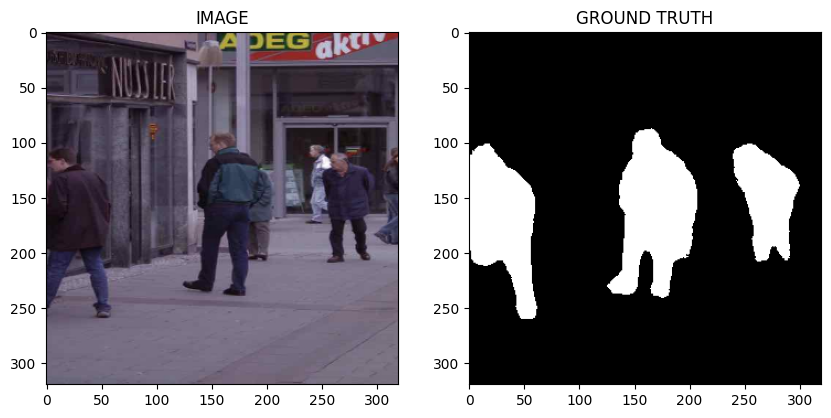

In [125]:
idx = 20
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))

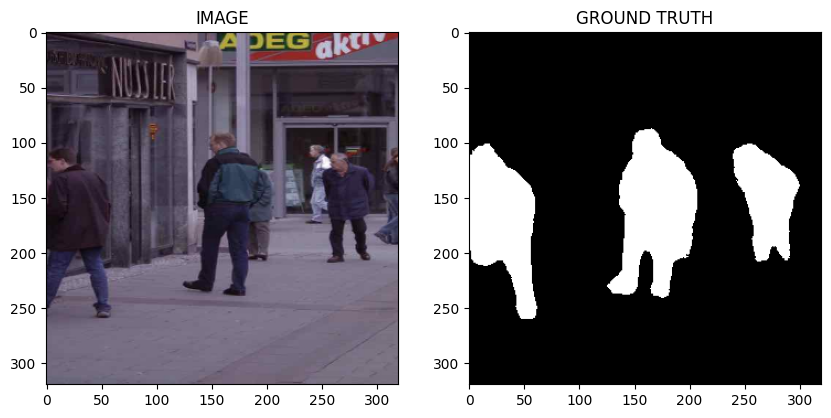

In [126]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

In [127]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

# Task 5 : Load dataset into batches

# Task 7 : Create Train and Validation Function